In [1]:
%pip install pandas psycopg2-binary sqlalchemy matplotlib scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import psycopg2 as db
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

In [3]:
db_type = 'postgresql'
host = 'database'
port = 5432
db_name = os.environ.get('POSTGRES_DB')
user = os.environ.get('POSTGRES_USER')
password = os.environ.get('POSTGRES_PASSWORD')

conn_uri = f"{db_type}://{user}:{password}@{host}:{port}/{db_name}"
alchemyEngine = create_engine(conn_uri)
db_conn = alchemyEngine.connect();

In [4]:
""" Query frequency perchase per user average in month """
db_conn = alchemyEngine.connect()
## Group user frequency
query = """
    SELECT
        user_id,
        AVG(times) as frequency
    FROM (
        SELECT
            user_id,
            COUNT(*) as times,
            DATE_TRUNC('month', event_time) AS month
        FROM customers
        WHERE event_type = 'purchase'
        GROUP BY user_id, month
        ORDER BY user_id, month
    ) AS user_month
    GROUP BY user_id
    ORDER BY user_id
"""
df = pd.read_sql(query, db_conn)
df.head()

,user_id,frequency
0,9794320,4.0
1,10079204,2.0
2,10280338,8.5
3,12055855,4.0
4,12936739,2.0


In [5]:
df.describe()

,user_id,frequency
count,9.265100e+04,92651.000000
mean,5.212751e+08,8.683773
std,8.685733e+07,10.463081
min,9.794320e+06,1.000000
25%,4.861277e+08,3.000000
50%,5.565920e+08,6.000000
75%,5.772530e+08,11.000000
max,6.088172e+08,438.000000


In [6]:
""" Segment Configure """
segment_config = {
    'segments': ['Inactive', 'New', 'Gold', 'Silver', 'Platinum'],
    'colors': ['#66c2a5', '#b3cde3', '#fdd9a0', '#c0c0c0', '#d9d9d9'],
    'sort_by': 0  # Index of feature to sort cluster centers by (e.g., frequency)
}
random_state = 42

In [7]:
"""" Standard Scaler """
X = df[['frequency']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.44765001],
       [-0.63879934],
       [-0.01756404],
       ...,
       [-0.44765001],
       [-0.06535137],
       [-0.54322467]], shape=(92651, 1))

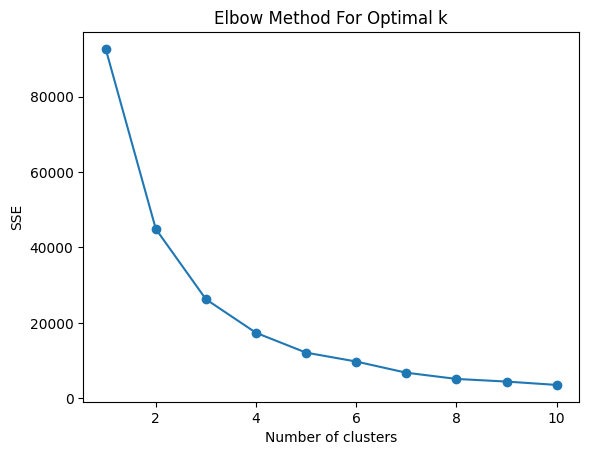

In [8]:
""" Plot Elbow Method Chart """
sse = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=random_state)
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.plot(K, sse, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

In [9]:
""" Clustering by 5 """
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
df['cluster'] = kmeans.fit_predict(X_scaled)
print(df['cluster'])

# See cluster center tendencies
cluster_centers = kmeans.cluster_centers_
kmeans.cluster_centers_

0        1
1        1
2        0
3        1
4        1
        ..
92646    1
92647    1
92648    1
92649    0
92650    1
Name: cluster, Length: 92651, dtype: int32


array([[ 0.28270456],
       [-0.4883573 ],
       [11.75130003],
       [ 4.11728959],
       [ 1.54198946]])

In [12]:
""" Bar Chart - Segment Clustering """
# # See cluster center tendencies
cluster_centers = kmeans.cluster_centers_
cluster_order = np.argsort([center[0] for center in cluster_centers])  # by frequency

segment_map = {cluster_order[i]: segment_config['segments'][i] for i in range(n_clusters)}
df['segment'] = df['cluster'].map(segment_map)
segment_counts = df['segment'].value_counts().reindex(segment_config['segments'])

print('DataFrame\n', df)
print(segment_counts)

DataFrame
          user_id  frequency  cluster   segment
0        9794320        4.0        1  Inactive
1       10079204        2.0        1  Inactive
2       10280338        8.5        0       New
3       12055855        4.0        1  Inactive
4       12936739        2.0        1  Inactive
...          ...        ...      ...       ...
92646  608807757        3.0        1  Inactive
92647  608809325        1.0        1  Inactive
92648  608809552        4.0        1  Inactive
92649  608812129        8.0        0       New
92650  608817151        3.0        1  Inactive

[92651 rows x 4 columns]
segment
Inactive    56746
New         26317
Gold         7878
Silver       1568
Platinum      142
Name: count, dtype: int64


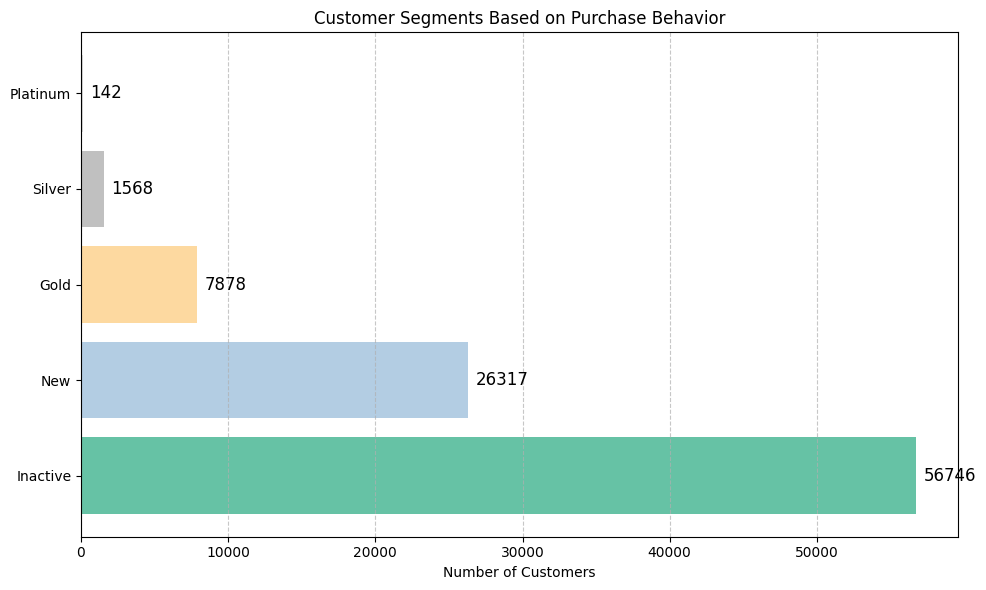

In [ ]:
""" Bar Chart - Ploting """
plt.figure(figsize=(10, 6))
bars = plt.barh(
    segment_counts.index,
    segment_counts.values,
    color=segment_config['colors']
)
## Add value label
for bar in bars:
    width = bar.get_width()
    plt.text(width + 500, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=12)

plt.xlabel('Number of Customers')
plt.title('Customer Segments Based on Purchase Behavior')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
""" Scatter plot each cluster """
# Find median in each clusters
cluster_medians = df.groupby('cluster')['frequency'].median().reset_index()

# Match segment to value
sorted_clusters = cluster_medians.sort_values('frequency').reset_index(drop=True)
label_map = {row['cluster']: segment_config['segments'][i] for i, row in sorted_clusters.iterrows()}
color_map = {row['cluster']: segment_config['colors'][i] for i, row in sorted_clusters.iterrows()}
cluster_medians['label'] = cluster_medians['cluster'].map(label_map)
cluster_medians['color'] = cluster_medians['cluster'].map(color_map)

cluster_medians

,cluster,frequency,label,color
0,0,11.000000,New,#b3cde3
1,1,3.000000,Inactive,#66c2a5
2,2,111.000000,Platinum,#d9d9d9
3,3,48.000000,Silver,#c0c0c0
4,4,23.333333,Gold,#fdd9a0


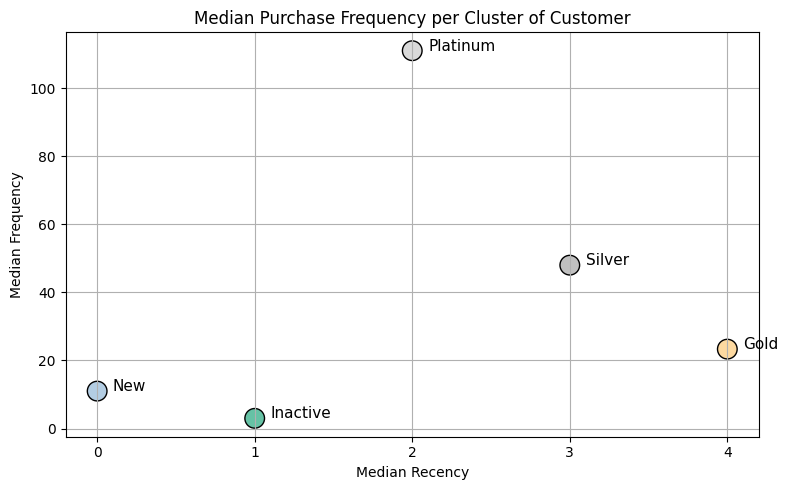

In [ ]:
""" Scatter Chart - Ploting """
# Plot as scatter chart
plt.figure(figsize=(8, 5))
plt.scatter(
    cluster_medians['cluster'],
    cluster_medians['frequency'],
    s=200,
    color=cluster_medians['color'],
    edgecolors='black'
)
# Annotate points
for i, row in cluster_medians.iterrows():
    plt.text(row['cluster'] + 0.1, row['frequency'], row['label'], fontsize=11)

plt.title('Median Purchase Frequency per Cluster of Customer')
plt.xlabel('Median Recency')
plt.ylabel('Median Frequency')
plt.xticks(cluster_medians['cluster'])
plt.grid(True)
plt.tight_layout()
plt.show()